In [2]:
import os
import pandas as pd
from sqlalchemy import create_engine, text
import geopandas as gpd

# Database Connection Setup
DB_USER = "greenway_admin"
DB_PASS = os.environ.get("GREENWAY_DB_PASS")
DB_HOST = "localhost"
DB_NAME = "greenway_db"

# Construct the connection string
connection_string = f"postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}/{DB_NAME}"
engine = create_engine(connection_string)

print("Database connection engine created successfully.")

Database connection engine created successfully.


In [14]:
# --- GeoPandas Data Verification (Cell 3) ---

# 1. Load Greenways Data into GeoDataFrame
greenways_gdf = gpd.read_postgis("SELECT * FROM greenways", engine, geom_col='geom')

# 2. Load Amenities Data into GeoDataFrame
amenities_gdf = gpd.read_postgis("SELECT * FROM amenities", engine, geom_col='geom')

# Display simple verification information
print("Greenway Verification")
print(f"\nTotal Features: {len(greenways_gdf)}")
print(f"Geometry Type: {greenways_gdf.geometry.geom_type.unique()}")
print(f"CRS (SRID): {greenways_gdf.crs}")
print("\nAmenities Verification")
print(f"\nTotal Features: {len(amenities_gdf)}")
print(f"Geometry Type: {amenities_gdf.geometry.geom_type.unique()}")
print(f"CRS (SRID): {amenities_gdf.crs}")

Greenway Verification

Total Features: 1266
Geometry Type: ['LineString' 'MultiLineString']
CRS (SRID): EPSG:4326

Amenities Verification

Total Features: 291
Geometry Type: ['Point']
CRS (SRID): EPSG:4326


In [12]:
print("Amenities GeoDataFrame Columns")
print("\n", amenities_gdf.columns.tolist())

Amenities GeoDataFrame Columns

 ['objectid', 'name', 'alias1', 'alias2', 'jurisdiction', 'address', 'address2', 'url', 'phone', 'artscenter', 'ballfields', 'boatrental', 'canoe', 'discgolf', 'dogpark', 'envctr', 'fishing', 'greenwayaccess', 'gym', 'multipurposefield', 'outdoorbasketball', 'picnicshelter', 'playground', 'pool', 'communitycenter', 'neighborhoodcenter', 'tenniscourts', 'track', 'walkingtrails', 'restrooms', 'lat', 'lon', 'notes', 'amusementtrain', 'carousel', 'tenniscenter', 'theater', 'bocce', 'handball', 'horseshoe', 'inlineskating', 'sandvolleyball', 'skatepark', 'active_adult', 'bmxtrack', 'boatride', 'library', 'museum', 'teen', 'biking', 'liveanimals', 'gardens', 'equestrian', 'forlocator', 'camping', 'geom']


In [20]:
# 1. Inspect the 'restrooms' column values
print("Unique Values in 'restrooms' Column")
print(amenities_gdf['restrooms'].value_counts(dropna=False))

Unique Values in 'restrooms' Column
restrooms
No      152
Yes     115
None     24
Name: count, dtype: int64


In [22]:
# Create a new GeoDataFrame containing only the amenities that have restrooms.
restrooms_gdf = amenities_gdf[amenities_gdf['restrooms'] == 'Yes'].copy()

# Verification of the new DataFrame
print(f"New GeoDataFrame 'restrooms_gdf' created.")
print(f"Total Restroom Features: {len(restrooms_gdf)}")

# Display the first few rows to confirm the filter worked
print("\nRestrooms GeoDataFrame Head")
print(restrooms_gdf[['name', 'address', 'restrooms']].head())

New GeoDataFrame 'restrooms_gdf' created.
Total Restroom Features: 115

Restrooms GeoDataFrame Head
                                          name  \
0                           Abbotts Creek Park   
1                                  Action Park   
2                             Ailey Young Park   
4   American Tobacco Trail - New Hill Entrance   
5  American Tobacco Trail - White Oak Entrance   

                                           address restrooms  
0                    9950 Durant Road, Raleigh, NC       Yes  
1          609 Wake Chapel Road, Fuquay-Varina, NC       Yes  
2               800 E Juniper Ave, Wake Forest, NC       Yes  
4  1309 New Hill-Olive Chapel Road, Apex, NC 27502       Yes  
5       1305 White Oak Church Road, Apex, NC 27523       Yes  


In [23]:
# Define the local Projected Coordinate System (NC State Plane) that uses meters instead of degrees.
TARGET_CRS = 'EPSG:32119'

# 1. Reproject the points (Restrooms)
# The .buffer() function we use later will create circles measured in meters.
restrooms_proj = restrooms_gdf.to_crs(TARGET_CRS)

# Reproject the lines (Greenways)
# The intersection operation requires all geometries to be in the same CRS.
greenways_proj = greenways_gdf.to_crs(TARGET_CRS)

print(f"Restrooms data CRS: {restrooms_proj.crs}")
print(f"Greenways data CRS: {greenways_proj.crs}")
print("Data successfully reprojected.")

Restrooms data CRS: EPSG:32119
Greenways data CRS: EPSG:32119
Data successfully reprojected.


In [24]:
# Define buffer distance (500 meters)
BUFFER_DISTANCE_M = 500

# Create a 500 meter buffer around each restroom point.
# The result is a GeoSeries of 500m circles (polygons) around the points.
restroom_buffers = restrooms_proj.buffer(BUFFER_DISTANCE_M)

print(f"Created a GeoSeries of {len(restroom_buffers)} buffers, each {BUFFER_DISTANCE_M} meters in radius.")
print(f"Example buffer geometry type: {restroom_buffers.iloc[0].geom_type}")

Created a GeoSeries of 115 buffers, each 500 meters in radius.
Example buffer geometry type: Polygon


In [26]:
# Apply the union_all() to merge all 115 polygons into one single geometry.
# This represents the total area within 500m of any restroom.
restroom_service_area = restroom_buffers.union_all()

# Verify that the result is a single geometry 
print(f"Restroom service area geometry type: {restroom_service_area.geom_type}")

Restroom service area geometry type: MultiPolygon


In [28]:
# Use the intersection method to clip the greenway lines against the single
# restroom service area polygon
accessible_greenways = greenways_proj.intersection(restroom_service_area)

# The result is a GeoSeries, but some segments might be empty (e.g., if they were points).
# Convert it into a GeoDataFrame for calculation.
# Rempty results and select the geometry column for calculation.
accessible_greenways_series = accessible_greenways[~accessible_greenways.is_empty]

# Verification
print(f"Intersection complete. Resulting GeoSeries has {len(accessible_greenways_series)} non-empty geometries.")
print(f"Example geometry type: {accessible_greenways_series.iloc[0].geom_type}")

Intersection complete. Resulting GeoSeries has 154 non-empty geometries.
Example geometry type: LineString


In [29]:
# Calculate the Lengths (meters)
total_accessible_length_m = accessible_greenways_series.length.sum()
total_greenway_length_m = greenways_proj.geometry.length.sum()

# Convert to Kilometers (rounded)
accessible_length_km = round(total_accessible_length_m / 1000, 2)
total_length_km = round(total_greenway_length_m / 1000, 2)

# Calculate the percentage 
accessibility_percentage = round((total_accessible_length_m / total_greenway_length_m) * 100, 1)

print("Restroom Accessibility Metrics (500m Buffer)")
print(f"Total Greenway Length: {total_length_km} km")
print(f"Accessible Greenway Length: {accessible_length_km} km")
print(f"Percentage of Greenways within 500m of a Restroom: **{accessibility_percentage}%**")

Restroom Accessibility Metrics (500m Buffer)
Total Greenway Length: 196.28 km
Accessible Greenway Length: 18.34 km
Percentage of Greenways within 500m of a Restroom: **9.3%**


In [30]:
# Redefine Buffer Distance
BUFFER_DISTANCE_M_1K = 1000 # Double the distance to 1 kilometer
print(f"Starting analysis with a {BUFFER_DISTANCE_M_1K}-meter buffer.")

# Re-run Buffering 
restroom_buffers_1k = restrooms_proj.buffer(BUFFER_DISTANCE_M_1K)
restroom_service_area_1k = restroom_buffers_1k.union_all()

# Re-run Intersection 
accessible_greenways_1k = greenways_proj.intersection(restroom_service_area_1k)
accessible_greenways_series_1k = accessible_greenways_1k[~accessible_greenways_1k.is_empty]

# Re-run Calculation 

# Calculate the Lengths (in meters)
total_accessible_length_m_1k = accessible_greenways_series_1k.length.sum()
total_greenway_length_m = greenways_proj.geometry.length.sum() 

# Convert to Kilometers (rounded)
accessible_length_km_1k = round(total_accessible_length_m_1k / 1000, 2)
total_length_km = round(total_greenway_length_m / 1000, 2)

# Calculate the percentage
accessibility_percentage_1k = round((total_accessible_length_m_1k / total_greenway_length_m) * 100, 1)

print("\n--- Restroom Accessibility Metrics (1,000m Buffer) ---")
print(f"Total Greenway Length: {total_length_km} km")
print(f"Accessible Greenway Length: {accessible_length_km_1k} km")
print(f"Percentage of Greenways within 1,000m of a Restroom: **{accessibility_percentage_1k}%**")

Starting analysis with a 1000-meter buffer.

--- Restroom Accessibility Metrics (1,000m Buffer) ---
Total Greenway Length: 196.28 km
Accessible Greenway Length: 57.58 km
Percentage of Greenways within 1,000m of a Restroom: **29.3%**


In [31]:
# Redefine Buffer Distance
BUFFER_DISTANCE_M_750 = 750 
print(f"Starting analysis with a {BUFFER_DISTANCE_M_750}-meter buffer.")

# Re-run Buffering
restroom_buffers_750 = restrooms_proj.buffer(BUFFER_DISTANCE_M_750)
restroom_service_area_750 = restroom_buffers_750.union_all()

# Re-run Intersection
accessible_greenways_750 = greenways_proj.intersection(restroom_service_area_750)
accessible_greenways_series_750 = accessible_greenways_750[~accessible_greenways_750.is_empty]

# Re-run Calculation
# Calculate the Lengths (in meters)
total_accessible_length_m_750 = accessible_greenways_series_750.length.sum()
total_greenway_length_m = greenways_proj.geometry.length.sum() # Total length remains the same

# Convert to Kilometers (rounded)
accessible_length_km_750 = round(total_accessible_length_m_750 / 1000, 2)
total_length_km = round(total_greenway_length_m / 1000, 2)

# Calculate the percentage
accessibility_percentage_750 = round((total_accessible_length_m_750 / total_greenway_length_m) * 100, 1)

print("\n--- Restroom Accessibility Metrics (750m Buffer) ---")
print(f"Total Greenway Length: {total_length_km} km")
print(f"Accessible Greenway Length: {accessible_length_km_750} km")
print(f"Percentage of Greenways within 750m of a Restroom: **{accessibility_percentage_750}%**")

Starting analysis with a 750-meter buffer.

--- Restroom Accessibility Metrics (750m Buffer) ---
Total Greenway Length: 196.28 km
Accessible Greenway Length: 37.65 km
Percentage of Greenways within 750m of a Restroom: **19.2%**


In [32]:
# Use the .difference() method to subtract the accessible segments from the entire network.
# .union_all() is used to treat the accessible series as a single geometry for subtraction.
inaccessible_greenways = greenways_proj.difference(accessible_greenways_series_750.union_all())

# Clean up any empty results from the difference operation
inaccessible_greenways_series = inaccessible_greenways[~inaccessible_greenways.is_empty]

print(f"Inaccessible GeoSeries created with {len(inaccessible_greenways_series)} non-empty segments.")

Inaccessible GeoSeries created with 1025 non-empty segments.


In [33]:
# The .difference() method subtracts one geometry from another.
# We subtract the unified accessible area (which is the union_all() of the accessible segments)
# from the entire greenways_proj GeoDataFrame.
inaccessible_greenways = greenways_proj.difference(accessible_greenways_series_750.union_all())

# Clean up any empty results from the difference operation
inaccessible_greenways_series = inaccessible_greenways[~inaccessible_greenways.is_empty]

# Verification
print(f"Inaccessible GeoSeries created with {len(inaccessible_greenways_series)} non-empty segments.")
print(f"Example geometry type: {inaccessible_greenways_series.iloc[0].geom_type}")

Inaccessible GeoSeries created with 1025 non-empty segments.
Example geometry type: LineString


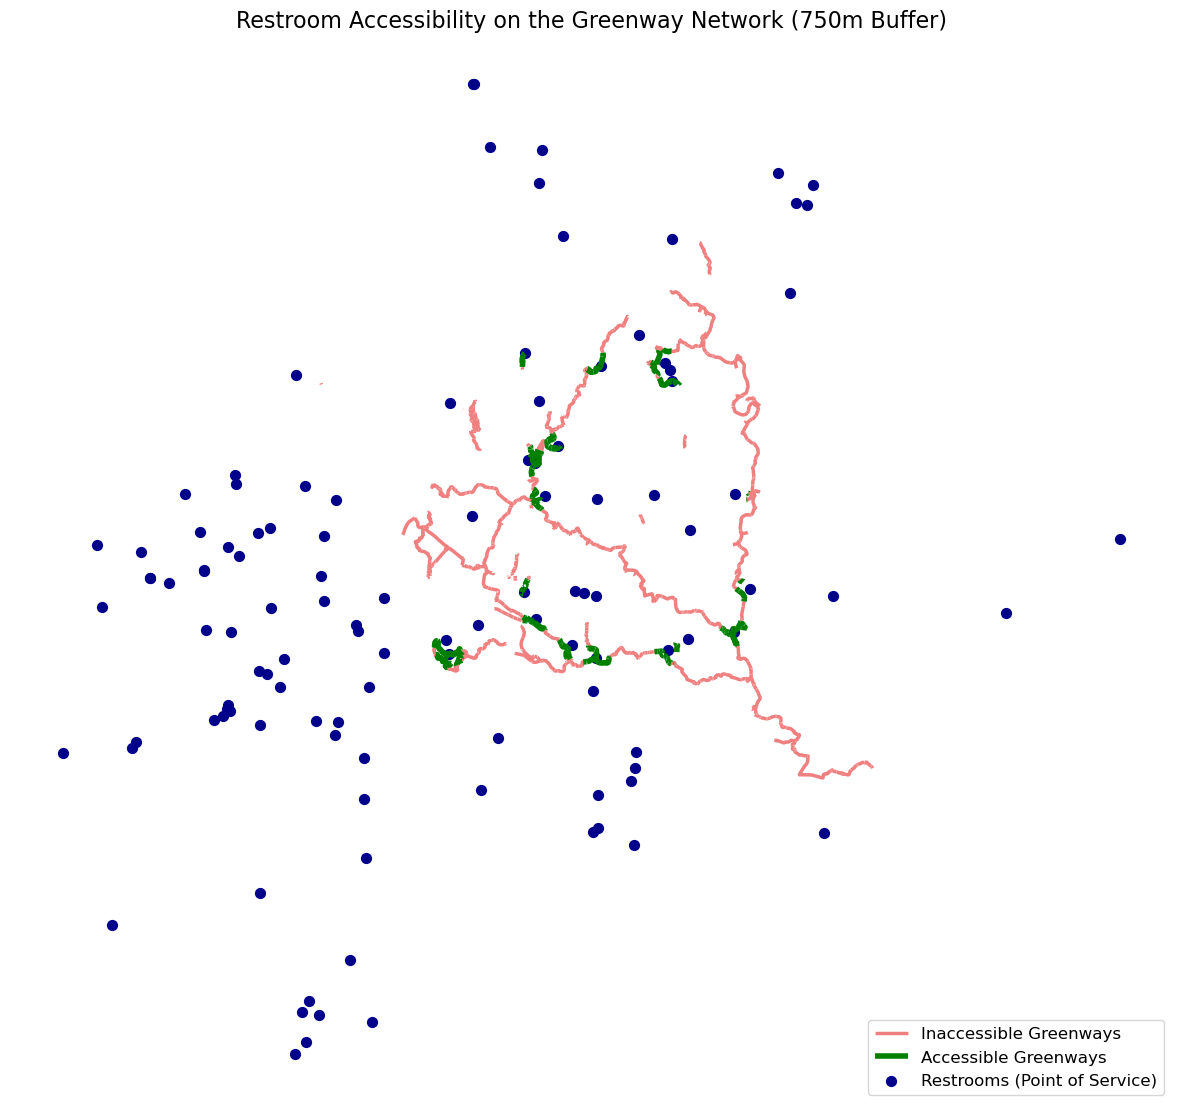


Map generated successfully! Check your file system for 'greenway_accessibility_map.png'.


In [35]:
import matplotlib.pyplot as plt

# Create GeoDataFrames from the GeoSeries
# Accessible
accessible_gdf = accessible_greenways_series_750.to_frame(name='geometry')
accessible_gdf['Access'] = 'Accessible (750m)'

# Inaccessible
inaccessible_gdf = inaccessible_greenways_series.to_frame(name='geometry')
inaccessible_gdf['Access'] = 'Inaccessible (>750m)'

# Create the Plot
# Set up the figure and axes
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.set_title('Restroom Accessibility on the Greenway Network (750m Buffer)', fontsize=16)
ax.set_axis_off() # Turn off the coordinates for a clean map look

# The Inaccessible sections (the background network)
inaccessible_gdf.plot(ax=ax, color='lightcoral', linewidth=2.5, label='Inaccessible Greenways')

# The Accessible sections (highlighted)
accessible_gdf.plot(ax=ax, color='green', linewidth=4, label='Accessible Greenways')

# The Restroom points
restrooms_proj.plot(ax=ax, marker='o', color='darkblue', markersize=50, label='Restrooms (Point of Service)')

# Add a legend
plt.legend(loc='lower right', frameon=True, fontsize=12)

# Save the map for your presentation
plt.savefig('greenway_accessibility_map.png', bbox_inches='tight')

# Show the plot
plt.show()

print("\nMap generated successfully! Check your file system for 'greenway_accessibility_map.png'.")

In [37]:
# RE-CALCULATE 500m BUFFER (KPI Table)
BUFFER_DISTANCE_M_500 = 500

# Buffering
restroom_buffers_500 = restrooms_proj.buffer(BUFFER_DISTANCE_M_500)
restroom_service_area_500 = restroom_buffers_500.union_all()

# Intersection
accessible_greenways_500 = greenways_proj.intersection(restroom_service_area_500)
accessible_greenways_series_500 = accessible_greenways_500[~accessible_greenways_500.is_empty]

# Calculation
total_accessible_length_m_500 = accessible_greenways_series_500.length.sum()
# total_greenway_length_m and other variables from the 750m run are still in memory

# Final 500m percentage
accessibility_percentage_500 = round((total_accessible_length_m_500 / total_greenway_length_m) * 100, 1)

# CREATE KPI SUMMARY TABLE
import pandas as pd

# Data from all three runs
summary_data = {
    'Buffer_Distance_m': [500, 750, 1000],
    'Round_Trip_Detour_km': [1.0, 1.5, 2.0],
    'Accessible_Length_km': [
        round(total_accessible_length_m_500 / 1000, 2), 
        accessible_length_km_750,                      
        accessible_length_km_1k                        
    ],
    'Accessibility_Percentage': [
        accessibility_percentage_500,                  
        accessibility_percentage_750,                  
        accessibility_percentage_1k                    
    ]
}

kpi_df = pd.DataFrame(summary_data)

print("Data for KPI Dashboard")
print(f"Total Network Length: {total_length_km} km")
print(kpi_df.to_markdown(index=False))

# Export the table as a CSV
kpi_df.to_csv('accessibility_kpi_summary.csv', index=False)

Data for KPI Dashboard
Total Network Length: 196.28 km
|   Buffer_Distance_m |   Round_Trip_Detour_km |   Accessible_Length_km |   Accessibility_Percentage |
|--------------------:|-----------------------:|-----------------------:|---------------------------:|
|                 500 |                    1   |                  18.34 |                        9.3 |
|                 750 |                    1.5 |                  37.65 |                       19.2 |
|                1000 |                    2   |                  57.58 |                       29.3 |


In [38]:
# Exporting Greenway Lines (750m)

# Combine the accessible and inaccessible GeoDataFrames into one
greenway_map_data = pd.concat([accessible_gdf, inaccessible_gdf])

# Export the combined lines to GeoJSON 
# Set the driver to 'GeoJSON' 
greenway_map_data.to_file('greenway_accessibility_lines_750m.geojson', driver='GeoJSON')
print("Exported: greenway_accessibility_lines_750m.geojson (Greenway Lines)")

# Exporting Restroom Points

# Export the point GeoDataFrame
restrooms_proj.to_file('restroom_locations.geojson', driver='GeoJSON')
print("Exported: restroom_locations.geojson (Restroom Points)")

print("\nGIS data files are now ready to be loaded into ArcGIS.")

Exported: greenway_accessibility_lines_750m.geojson (Greenway Lines)
Exported: restroom_locations.geojson (Restroom Points)

GIS data files are now ready to be loaded into ArcGIS.
